In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from src.utils import evaluate_reductions
from src.estimates import get_confidence_estimates
from src.metrics import adaptive_calibration_error

In [19]:
graphics_format = ".png"
graphics_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Graphics/"
tables_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Tables/"
list_of_all_models = [x for x in os.listdir("../results/scores") if not x.startswith(".")]

# Experiment 1: Token Log-Likelihood Reduction Strategy Evaluation

In [20]:
# Evaluate over all models
if os.path.isfile("../results/reduction_strategies.json"):
    reduction_results = pd.read_json(
        "../results/reduction_strategies.json",
        orient="records",
        lines=True)
else:
    reduction_results = evaluate_reductions(models=list_of_all_models)
    reduction_results.to_json("../results/reduction_strategies.json", orient="records", lines=True)

In [21]:
# Adding the harmonic mean to the results: 2*ACC*(1-ACE)/(ACC+(1-ACE))
acc = reduction_results["accuracy"]
ace = reduction_results["ace"]
reduction_results["harmonic_mean"] = (2*acc*(1-ace))/(acc+(1-ace))

In [22]:
reduction_labels = {
    "pll_scores_sum": "Sum",
    "pll_scores_avg": "Mean",
    "pll_scores_answer_sum": "Sum (A)",
    "pll_scores_answer_avg": "Mean (A)",
}
reduction_results["reduction"] = reduction_results["reduction"].map(reduction_labels)
reduction_results.round(3)

,model,model_type,reduction,accuracy,ace,harmonic_mean
0,opt-350m,CLM,Sum,0.204,0.265,0.320
1,opt-350m,CLM,Mean,0.087,0.052,0.160
2,opt-350m,CLM,Sum (A),0.208,0.256,0.326
3,opt-350m,CLM,Mean (A),0.136,0.165,0.234
4,opt-125m,CLM,Sum,0.175,0.299,0.280
...,...,...,...,...,...,...
59,gemma-7b,CLM,Mean (A),0.537,0.064,0.682
60,bert-large-cased,MLM,Sum,0.208,0.452,0.302
61,bert-large-cased,MLM,Mean,0.166,0.040,0.284
62,bert-large-cased,MLM,Sum (A),0.143,0.340,0.235


### Figure 5.1: Bar Plot Reduction Strategies (Accuracy, ACE, Harmonic-Mean)

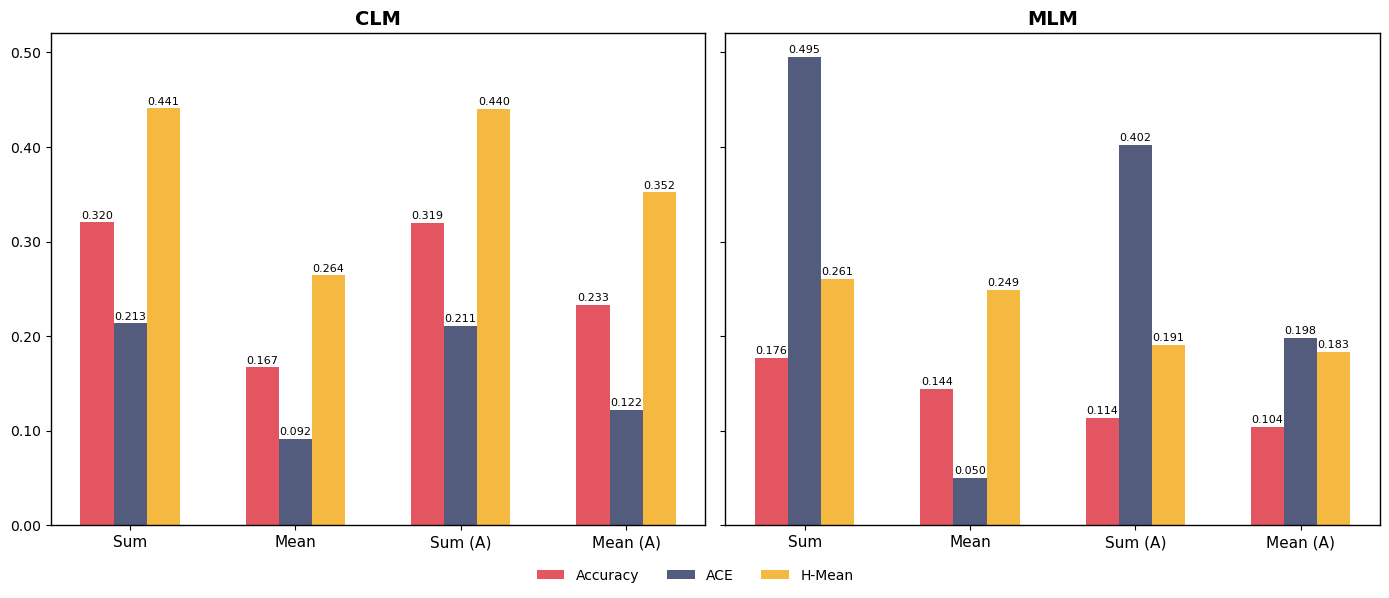

In [23]:
mean_per_metric = (
    reduction_results.groupby(["reduction", "model_type"])[["accuracy", "ace", "harmonic_mean"]]
    .mean()
    .reset_index()
)

metric_labels = {"accuracy": "Accuracy", "ace": "ACE", "harmonic_mean": "H-Mean"}
df = mean_per_metric.melt(
    id_vars=["reduction", "model_type"],
    value_vars=metric_labels.keys(),
    var_name="metric",
    value_name="value"
)
df["metric"] = df["metric"].map(metric_labels)

colors = {"Accuracy": "#db2b39", "ACE": "#29335c", "H-Mean": "#f3a712"}
reductions = ["Sum", "Mean", "Sum (A)", "Mean (A)"]
metrics = list(colors.keys())
model_types = df["model_type"].unique()

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

x = np.arange(len(reductions))
bar_width = 0.2

for ax, model_type in zip(axs, model_types):
    data = df[df["model_type"] == model_type]
    for i, metric in enumerate(metrics):
        values = (
            data[data["metric"] == metric]
            .set_index("reduction")
            .reindex(reductions)["value"]
            .values
        )
        ax.bar(x + i * bar_width, values, width=bar_width, label=metric, color=colors[metric], alpha=0.8)
        for xi, v in zip(x, values):
            ax.text(xi + i * bar_width, v + 0.002, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(reductions, fontsize=11)
    ax.set_title(model_type, fontsize=14, fontweight="bold")
    ax.set_facecolor("white")
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color("black")

fig.legend(metrics, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 0))
fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(graphics_path + "reductions_barplot" + graphics_format, bbox_inches="tight", dpi=600)
plt.show()

### Appendix B: Harmonic Means, Accuracy and ACE for each model and reduction strategy

In [24]:
# Harmonic Mean
(
    reduction_results
    .pivot(columns="reduction", index="model", values="harmonic_mean")
    .reset_index()
    .set_index("model")
    .round(3)[["Sum", "Mean", "Sum (A)", "Mean (A)"]]
).to_latex(tables_path + "table_d2.txt", float_format="%.3f", header=True)

In [25]:
# Accuracy 
(
    reduction_results
    .pivot(columns="reduction", index="model", values="accuracy")
    .reset_index()
    .set_index("model")
    .round(3)[["Sum", "Mean", "Sum (A)", "Mean (A)"]]
)

reduction,Sum,Mean,Sum (A),Mean (A)
model,,,,
bert-base-cased,0.192,0.153,0.124,0.108
bert-large-cased,0.208,0.166,0.143,0.135
gemma-2b,0.529,0.312,0.521,0.412
gemma-7b,0.664,0.395,0.657,0.537
gpt2,0.149,0.070,0.150,0.091
gpt2-large,0.235,0.118,0.236,0.154
gpt2-medium,0.207,0.095,0.211,0.131
gpt2-xl,0.276,0.144,0.277,0.186
opt-1.3b,0.322,0.152,0.320,0.236


In [26]:
# ACE
(
    reduction_results
    .pivot(columns="reduction", index="model", values="ace")
    .reset_index()
    .set_index("model")
    .round(3)[["Sum", "Mean", "Sum (A)", "Mean (A)"]]
)

reduction,Sum,Mean,Sum (A),Mean (A)
model,,,,
bert-base-cased,0.454,0.036,0.371,0.202
bert-large-cased,0.452,0.040,0.340,0.187
gemma-2b,0.113,0.189,0.127,0.039
gemma-7b,0.077,0.266,0.090,0.064
gpt2,0.295,0.044,0.286,0.216
gpt2-large,0.236,0.040,0.230,0.144
gpt2-medium,0.249,0.044,0.242,0.165
gpt2-xl,0.240,0.052,0.232,0.121
opt-1.3b,0.207,0.064,0.202,0.069


### Figure 5.2: Distribution of Opt-1.3b softmax confidence scores

In [27]:
# Load model results for opt-1.3b
reductions = ["sum", "mean"]
data_rows = []

for reduction in reductions:
    for only_answers in [False, True]:
        result = get_confidence_estimates(
            "opt-1.3b",
            reduction=reduction,
            only_answers=only_answers
        )
        row = {
            "reduction": reduction,
            "only_answers": only_answers,
            "predictions": result["correctly_predicted"],
            "confidence": result["base_conf"]
        }
        data_rows.append(row)
results_df = pd.DataFrame(data_rows)

In [28]:
c_sum = results_df[
    (results_df["reduction"] == "sum") &
    (results_df["only_answers"] == False)]["confidence"].iloc[0]

c_mean = results_df[
    (results_df["reduction"] == "mean") &
    (results_df["only_answers"] == False)]["confidence"].iloc[0]

c_sum_a = results_df[
    (results_df["reduction"] == "sum") &
    (results_df["only_answers"] == True)]["confidence"].iloc[0]

c_mean_a = results_df[
    (results_df["reduction"] == "mean") &
    (results_df["only_answers"] == True)]["confidence"].iloc[0]

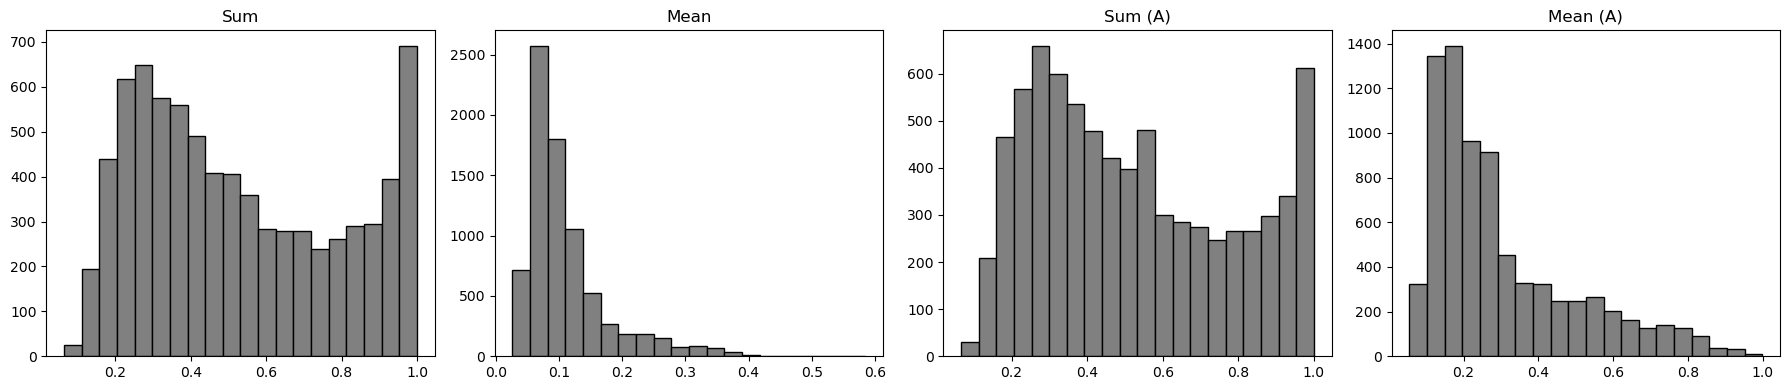

In [29]:
confidence_sets = [c_sum, c_mean, c_sum_a, c_mean_a]
titles = ["Sum", "Mean", "Sum (A)", "Mean (A)"]

fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)
axes = axes.flatten()

for ax, data, title in zip(axes, confidence_sets, titles):
    ax.hist(data, bins=20, color="gray", edgecolor="black")
    ax.set_facecolor("white")
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.savefig(graphics_path + "dist_confs_opt13b" + graphics_format, dpi=600)
plt.show()

### ACE of Opt-1.3b separately for correct and incorrect predictions.

In [30]:
p_mean = results_df[
    (results_df["reduction"] == "mean") &
    (results_df["only_answers"] == False)]["predictions"].iloc[0]
c_mean_t = c_mean[p_mean]
c_mean_f = c_mean[~p_mean]
p_mean_t = p_mean[p_mean].astype(int)
p_mean_f = p_mean[~p_mean].astype(int)
print("Correct:", adaptive_calibration_error(p_mean_t, c_mean_t),
      "\nIncorrect:", adaptive_calibration_error(p_mean_f, c_mean_f))

Correct: 0.8779525555867277 
Incorrect: 0.10780000845654047


In [14]:
bert_base = get_confidence_estimates("bert-base-cased", reduction="mean", only_answers=False)

In [15]:
adaptive_calibration_error(
    bert_base["correctly_predicted"].tolist(),
    bert_base["base_conf"].tolist(),
    n_bins=20
)

0.03631055185109754